<a href="https://colab.research.google.com/github/OmarFG7/PC2/blob/master/PROYECTO_FINAL_GEPRO_(IDENTIFICADOR_DE_TELAS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Crear las carpetas para subir las imagenes
!mkdir ropa
!mkdir defectos


In [2]:
#Entrar en cada carpeta y descomprimir el archivo zip
%cd ropa
!unzip ropa.zip
%cd ..

%cd defectos
!unzip defectos.zip
%cd ..


/content/ropa
Archive:  ropa.zip
  inflating: 0000222004_9_1_13.jpg   
  inflating: 006_400x.jpg            
  inflating: 008_ebbfabca-9875-4413-b36b-749556c65771.JPG.jpg  
  inflating: 00f4b7dea8a32c8b1ef20a153460806ac086562c_cmy0390_1.jpg  
  inflating: 01_corazon-720x900.jpg  
  inflating: 012422-shirts-for-men-lead.jpg  
  inflating: 0158b5f8_2a3b.jpg       
  inflating: 0181ecd047e36e44d956cb2388e8ed08.jpg  
  inflating: 028b961e64fa848f11ffb7afd79ef64e_1_x600.jpg  
  inflating: 030a0b25b31b2cc45939688e6ecce3e6.jpg  
  inflating: 05_Straight_08785555-50ec-48b5-afc2-e352e451c269.jpg  
  inflating: 0731516000016_PR9100_261_A.jpg  
  inflating: 0b04fef43fb701da4d4fcef52b3fc171.jpg  
  inflating: 0ccc1c416c69ec0737c578ac68009906.jpg  
  inflating: 0f9ece3605c4b05bbefb97c697a03ff0.jpg  
  inflating: 1_9eaefeb2-c992-463d-b567-731b102ecf1a.jpg  
  inflating: 100075501_28R_1920x2880.jpg  
  inflating: 100-25-cotton-fancy-casual-shirt-for-men-500x500-500x500.jpg  
  inflating: 1026728-00-0

In [3]:
#Borrar los archivo ZIP
!rm -rf /content/defectos/defectos.zip
!rm -rf /content/ropa/ropa.zip


In [4]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls /content/ropa | wc -l #887
!ls /content/defectos | wc -l #43

887
43


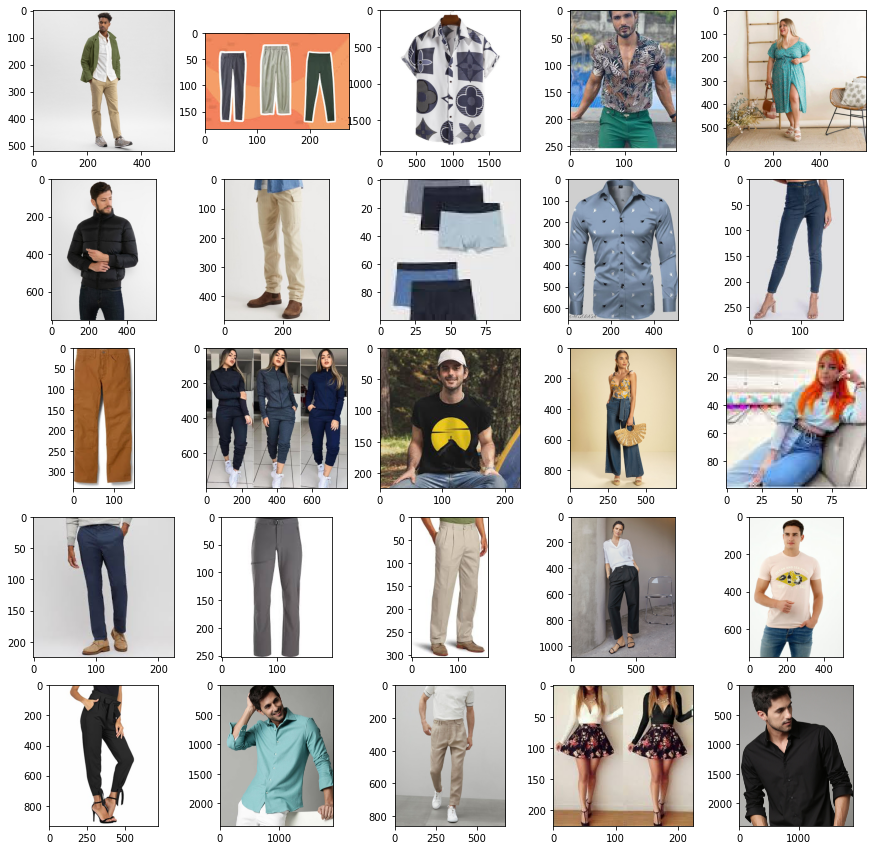

In [5]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = '/content/ropa'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [6]:
#Crear carpetas para hacer el set de datos

!mkdir dataset
!mkdir dataset/ropas
!mkdir dataset/defecto

In [7]:
#Copiar imagenes que subimos a carpetas del dataset
#Limitar para que todos tengan la misma cantidad de imagenes
#maximo 43 (el num. menor de imagenes que subi)

import shutil
carpeta_fuente = '/content/ropa'
carpeta_destino = '/content/dataset/ropas'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 43:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [8]:
carpeta_fuente = '/content/defectos'
carpeta_destino = '/content/dataset/defecto'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 43:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [9]:
#Mostrar cuantas imagenes tengo de cada categoria en el dataset
!ls /content/dataset/ropas | wc -l
!ls /content/dataset/defecto | wc -l

43
43


Found 70 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


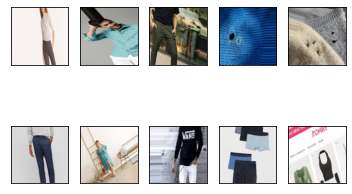

In [10]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


In [11]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [12]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [13]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2, activation='softmax')
])

In [14]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
#Compilar
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
#Entrenar el modelo
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/50
3/3 [==============================] - 10s 2s/step - loss: 0.9711 - accuracy: 0.4714 - val_loss: 0.5891 - val_accuracy: 0.6875
Epoch 2/50
3/3 [==============================] - 5s 1s/step - loss: 0.6542 - accuracy: 0.6429 - val_loss: 0.3931 - val_accuracy: 0.8125
Epoch 3/50
3/3 [==============================] - 4s 2s/step - loss: 0.3956 - accuracy: 0.8857 - val_loss: 0.2506 - val_accuracy: 0.9375
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.3343 - accuracy: 0.8857 - val_loss: 0.2139 - val_accuracy: 0.9375
Epoch 5/50
3/3 [==============================] - 5s 1s/step - loss: 0.2555 - accuracy: 0.8857 - val_loss: 0.2099 - val_accuracy: 1.0000
Epoch 6/50
3/3 [==============================] - 6s 3s/step - loss: 0.2089 - accuracy: 0.9000 - val_loss: 0.1520 - val_accuracy: 0.9375
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.1452 - accuracy: 0.9429 - val_loss: 0.0899 - val_accuracy: 1.0000
Epoch 8/50
3/3 [========================

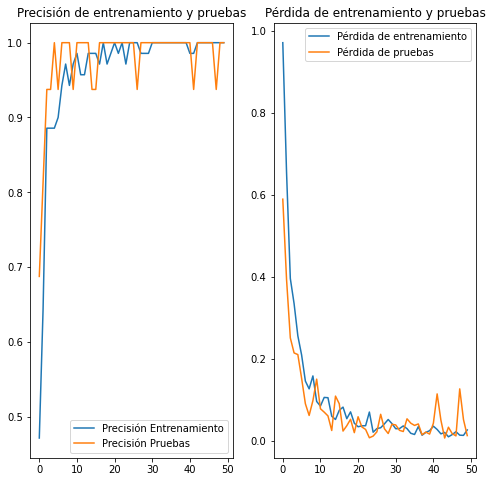

In [17]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [18]:
#Categorizar una imagen de internet
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)


In [28]:
#0 = con defectos, 1 = ropa sin defectos, 2 = tenedor
url = 'https://www.pequeocio.com/wp-content/uploads/2015/05/pantalones-rotos-ni%C3%B1os-5.jpg.webp' 
prediccion = categorizar (url)
print(prediccion)

1


**PRUEBA**


---




In [29]:
#Exportar el modelo en formato h5
modelo.save('identificador-telas.h5')

In [30]:
#El equipo es Linux. Listemos el contenido de la carpeta actual para ver que se exporto el modelo
!ls

dataset  defectos  identificador-telas.h5  ropa  sample_data


### #Para convertirlo a tensorflow.js, primero debemos instalar la libreria

In [ ]:
!pip install tensorflowjs

### #Crear carpeta donde se colocaran los archivos resultantes

In [32]:
!mkdir carpeta_salida

### #Realizar la exportacion a la carpeta de salida


In [33]:
!tensorflowjs_converter --input_format keras identificador-telas.h5 carpeta_salida

### #Confirmar que en la carpeta de salida se hayan generado los archivos. Deben aparecer archivos "bin" y "json"


In [34]:
!ls carpeta_salida

group1-shard1of3.bin  group1-shard2of3.bin  group1-shard3of3.bin  model.json




---


CREAR Y ALOJAR LA PAGINA WEB

---



In [37]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(8000)"))

https://5ntk7jqpb96-496ff2e9c6d22116-8000-colab.googleusercontent.com/


In [ ]:
!python -m http.server 8000



Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...




---



In [39]:
#Crear la carpeta para exportarla a TF Serving
!mkdir -p carpeta_salida/modelo_cocina/1

In [40]:
#Guardar el modelo en formato SavedModel
modelo.save('carpeta_salida/modelo_cocina/1')

INFO:tensorflow:Assets written to: carpeta_salida/modelo_cocina/1/assets


INFO:tensorflow:Assets written to: carpeta_salida/modelo_cocina/1/assets


In [41]:
#Hacerlo un zip para bajarlo y usarlo en otro lado
!zip -r modelo_cocina.zip /content/carpeta_salida/modelo_cocina/

  adding: content/carpeta_salida/modelo_cocina/ (stored 0%)
  adding: content/carpeta_salida/modelo_cocina/1/ (stored 0%)
  adding: content/carpeta_salida/modelo_cocina/1/keras_metadata.pb (deflated 81%)
  adding: content/carpeta_salida/modelo_cocina/1/assets/ (stored 0%)
  adding: content/carpeta_salida/modelo_cocina/1/variables/ (stored 0%)
  adding: content/carpeta_salida/modelo_cocina/1/variables/variables.index (deflated 78%)
  adding: content/carpeta_salida/modelo_cocina/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/carpeta_salida/modelo_cocina/1/saved_model.pb (deflated 92%)
